# Loopy and unloopy programming techniques

This notebook uses the packages and versions described in [requirements.txt](https://github.com/jpivarski/scipy2022-loopy/blob/main/requirements.txt).

Note that `awkward._v2` is a preview of Awkward Array 2.0, which will be released in December 2022.

In [1]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import awkward._v2 as ak

# Part 1: Array-oriented programming and its advantages

<br><br><br><br><br>

# Part 2: Limitations of array-oriented programming

<br><br><br><br><br>

# Intermezzo: Array-oriented programming as vectorization

<br><br><br><br><br>

# Part 3: Arbitrary data structures in array-oriented programming

So far, all of the arrays we've dealt with have been rectangular.

<img src="https://upload.wikimedia.org/wikipedia/commons/0/06/8-layer_cube.jpg" width="400">

What about other data structures? What if we want variable-length lists or nested records or something?

```python
[
    [{"x": 1.1, "y": [1]}, {"x": 2.2, "y": [1, 2]}, {"x": 3.3, "y": [1, 2, 3]}],
    [],
    [{"x": 4.4, "y": [1, 2, 3, 4]}, {"x": 5.5, "y": [1, 2, 3, 4, 5]}]
]
```

(The array above contains lists of records with fields `"x"` and `"y"`; the `"x"` field has floating point numbers and the `"y"` field has lists of integers.)

<br><br><br>

Interactive, array-oriented languages are fast because they launch precompiled routines on data that are densely packed in memory. It would seem like this could _only_ work for rectangular arrays.

Until about 5 years ago, that was the case.

<img src="https://svn.apache.org/repos/asf/comdev/project-logos/originals/arrow.svg" width="400">

Apache Arrow is a _columnar_ format for data in memory that is capable of complex data structures.

In [2]:
import pyarrow as pa

In [3]:
arrow_array = pa.array([
    [{"x": 1.1, "y": [1]}, {"x": 2.2, "y": [1, 2]}, {"x": 3.3, "y": [1, 2, 3]}],
    [],
    [{"x": 4.4, "y": [1, 2, 3, 4]}, {"x": 5.5, "y": [1, 2, 3, 4, 5]}]
])

In [4]:
arrow_array

[
  -- is_valid: all not null
  -- child 0 type: double
    [
      1.1,
      2.2,
      3.3
    ]
  -- child 1 type: list<item: int64>
    [
      [
        1
      ],
      [
        1,
        2
      ],
      [
        1,
        2,
        3
      ]
    ],
  -- is_valid: all not null
  -- child 0 type: double
    []
  -- child 1 type: list<item: int64>
    [],
  -- is_valid: all not null
  -- child 0 type: double
    [
      4.4,
      5.5
    ]
  -- child 1 type: list<item: int64>
    [
      [
        1,
        2,
        3,
        4
      ],
      [
        1,
        2,
        3,
        4,
        5
      ]
    ]
]

In [5]:
arrow_array.to_pylist()

[[{'x': 1.1, 'y': [1]}, {'x': 2.2, 'y': [1, 2]}, {'x': 3.3, 'y': [1, 2, 3]}],
 [],
 [{'x': 4.4, 'y': [1, 2, 3, 4]}, {'x': 5.5, 'y': [1, 2, 3, 4, 5]}]]

<br><br><br>

You can do _some_ NumPy-like operations on it.

In [6]:
arrow_array[1:].to_pylist()

[[], [{'x': 4.4, 'y': [1, 2, 3, 4]}, {'x': 5.5, 'y': [1, 2, 3, 4, 5]}]]

In [7]:
arrow_array.take([0, 2]).to_pylist()

[[{'x': 1.1, 'y': [1]}, {'x': 2.2, 'y': [1, 2]}, {'x': 3.3, 'y': [1, 2, 3]}],
 [{'x': 4.4, 'y': [1, 2, 3, 4]}, {'x': 5.5, 'y': [1, 2, 3, 4, 5]}]]

<br><br><br>

Internally, the data structure is a collection of densely packed buffers.

The boundaries between lists and the record field names are a high-level view of this low-level information.

In [8]:
arrow_array.buffers()

[None,
 None,
 None,
 None,
 None,

In [9]:
np.frombuffer(arrow_array.buffers()[1], np.int32)

array([0, 3, 3, 5], dtype=int32)

In [10]:
np.frombuffer(arrow_array.buffers()[4], np.float64)

array([1.1, 2.2, 3.3, 4.4, 5.5])

In [11]:
np.frombuffer(arrow_array.buffers()[6], np.int32)

array([ 0,  1,  3,  6, 10, 15], dtype=int32)

In [12]:
np.frombuffer(arrow_array.buffers()[8], np.int64)

array([1, 1, 2, 1, 2, 3, 1, 2, 3, 4, 1, 2, 3, 4, 5])

<br><br><br>

The primary focus of the Arrow project is to share memory between languages and between applications:

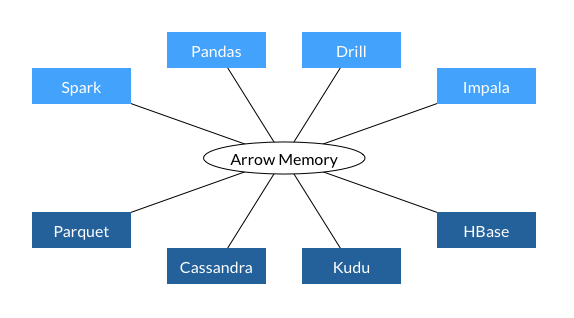

In a way that allows for faster (vectorized, CPU cache-friendly) computations:

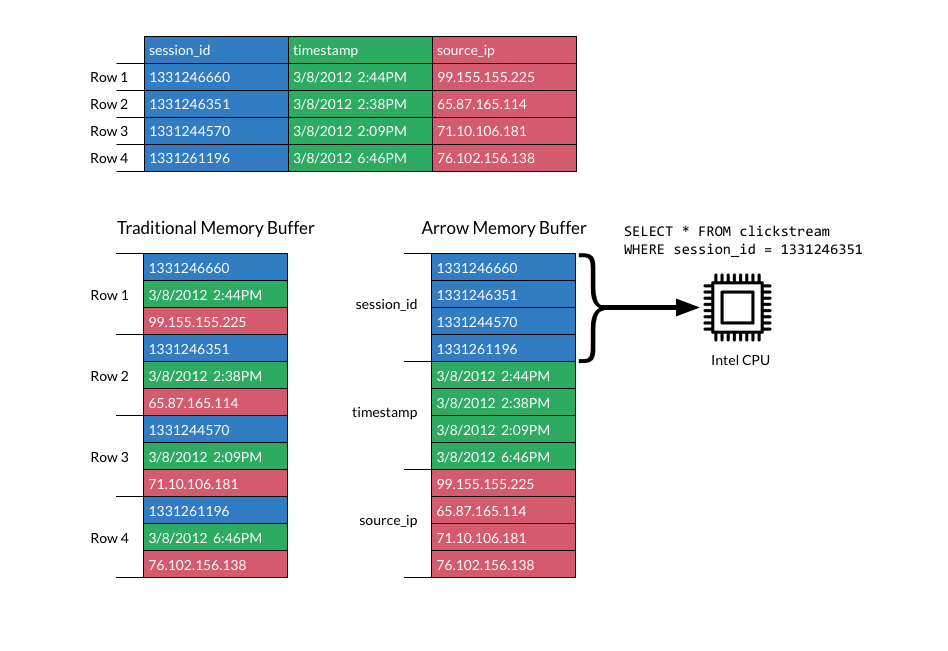

But it can be a struggle to use as a _direct_ user interface for statistical applications.

One of the tools in the Arrow ecosystem presents these arrays as generalizations of NumPy arrays.

<img src="https://raw.githubusercontent.com/scikit-hep/awkward/main/docs-img/logo/logo.svg" width="400">

In [13]:
awkward_array = ak.from_arrow(arrow_array)

A more concise `repr`:

In [14]:
awkward_array

<Array [[{x: 1.1, y: [1]}, ..., {...}], ...] type='3 * var * ?{x: ?float64,...'>

that can be expanded out:

In [15]:
awkward_array.show()

[[{x: 1.1, y: [1]}, {x: 2.2, y: [...]}, {x: 3.3, y: [1, 2, 3]}],
 [],
 [{x: 4.4, y: [1, 2, 3, 4]}, {x: 5.5, y: [1, ..., 5]}]]


including the data type:

In [16]:
awkward_array.type.show()

3 * var * ?{
    x: ?float64,
    y: option[var * ?int64]
}


<br><br><br>

Just as with Arrow, you can peek inside an Awkward Array to see its internal structure.

It's a tree with Arrow's `buffers` at various nodes of the tree.

In [17]:
awkward_array.layout

<ListOffsetArray len='3'>
    <offsets><Index dtype='int32' len='4'>[0 3 3 5]</Index></offsets>
    <content><UnmaskedArray len='5'>
        <content><RecordArray is_tuple='false' len='5'>
            <content index='0' field='x'>
                <UnmaskedArray len='5'>
                    <content><NumpyArray dtype='float64' len='5'>[1.1 2.2 3.3 4.4 5.5]</NumpyArray></content>
                </UnmaskedArray>
            </content>
            <content index='1' field='y'>
                <UnmaskedArray len='5'>
                    <content><ListOffsetArray len='5'>
                        <offsets><Index dtype='int32' len='6'>
                            [ 0  1  3  6 10 15]
                        </Index></offsets>
                        <content><UnmaskedArray len='15'>
                            <content><NumpyArray dtype='int64' len='15'>
                                [1 1 2 1 2 3 1 2 3 4 1 2 3 4 5]
                            </NumpyArray></content>
                        <

<br><br><br>

Most importantly, you can use the array as you would in NumPy.

**Slicing through a record field:**

In [18]:
awkward_array.show()

[[{x: 1.1, y: [1]}, {x: 2.2, y: [...]}, {x: 3.3, y: [1, 2, 3]}],
 [],
 [{x: 4.4, y: [1, 2, 3, 4]}, {x: 5.5, y: [1, ..., 5]}]]


In [19]:
awkward_array["x"].show()

[[1.1, 2.2, 3.3],
 [],
 [4.4, 5.5]]


**Slicing multiple dimensions at once:**

In [20]:
awkward_array["x", [True, False, True]].show()

[[1.1, 2.2, 3.3],
 [4.4, 5.5]]


In [21]:
awkward_array["x", [True, False, True], 1].show()

[2.2,
 5.5]


**Mathematical expressions on the numerical values, preserving structure:**

In [22]:
np.sqrt(awkward_array).show()

[[{x: 1.05, y: [1]}, {x: 1.48, y: ..., ...}, {x: 1.82, y: [1, ..., 1.73]}],
 [],
 [{x: 2.1, y: [1, 1.41, 1.73, 2]}, {x: 2.35, y: [1, ...]}]]


**Reductions at various levels:**

<img src="../img/example-reduction-sum.svg" width="500">

In [23]:
awkward_array["x"].show()

[[1.1, 2.2, 3.3],
 [],
 [4.4, 5.5]]


In [24]:
print(ak.sum(awkward_array["x"], axis=0))

[5.5, 7.7, 3.3]


In [25]:
ak.sum(awkward_array["x"], axis=1).show()

[6.6,
 0,
 9.9]


In [26]:
awkward_array["y"].show()

[[[1], [1, 2], [1, 2, 3]],
 [],
 [[1, 2, 3, 4], [1, 2, 3, 4, 5]]]


In [27]:
ak.sum(awkward_array["y"], axis=-1).show()

[[1, 3, 6],
 [],
 [10, 15]]


**And broadcasting:**

In [28]:
(100 + awkward_array["y"]).show()

[[[101], [101, 102], [101, 102, 103]],
 [],
 [[101, 102, 103, 104], [101, 102, 103, 104, 105]]]


In [29]:
(awkward_array["x"] + awkward_array["y"]).show()

[[[2.1], [3.2, 4.2], [4.3, 5.3, 6.3]],
 [],
 [[5.4, 6.4, 7.4, 8.4], [6.5, 7.5, 8.5, 9.5, 10.5]]]


<br><br><br>

Putting this all together, array-oriented operations on data structures can be more succinct than imperative operations on the same structures.

The following selects field `"y"`, drops element `0` from each of the innermost lists (`...` to apply the slice to the last dimension), then squares the results.

In [37]:
output = np.square(awkward_array["y", ..., 1:])

output.show(type=True)

type: 3 * var * option[var * ?int64]
[[[], [4], [4, 9]],
 [],
 [[4, 9, 16], [4, 9, 16, 25]]]


Below is how you'd have to do it with `for` loops.

Most of the boilerplate is breaking down and building up nested lists.

In [31]:
output = []
for sublist in awkward_array:
    tmp1 = []
    for record in sublist:
        tmp2 = []
        for number in record["y"][1:]:
            tmp2.append(np.square(number))
        tmp1.append(tmp2)
    output.append(tmp1)

output

[[[], [4], [4, 9]], [], [[4, 9, 16], [4, 9, 16, 25]]]

<br><br><br>

It also scales better with big datasets. In Python, each object is a tree of class instances containing their attributes.

In [32]:
big_list = [
    [{"x": 1.1, "y": [1]}, {"x": 2.2, "y": [1, 2]}, {"x": 3.3, "y": [1, 2, 3]}],
    [],
    [{"x": 4.4, "y": [1, 2, 3, 4]}, {"x": 5.5, "y": [1, 2, 3, 4, 5]}]
] * 100000

In [33]:
big_array = ak.Array(big_list)

Arrow and Awkward Array data are a single tree for the whole dataset with all the numerical data in the associated `buffers`.

In [34]:
big_array.layout

<ListOffsetArray len='300000'>
    <offsets><Index dtype='int64' len='300001'>
        [     0      3      3 ... 499998 499998 500000]
    </Index></offsets>
    <content><RecordArray is_tuple='false' len='500000'>
        <content index='0' field='x'>
            <NumpyArray dtype='float64' len='500000'>[1.1 2.2 3.3 ... 3.3 4.4 5.5]</NumpyArray>
        </content>
        <content index='1' field='y'>
            <ListOffsetArray len='500000'>
                <offsets><Index dtype='int64' len='500001'>
                    [      0       1       3 ... 1499991 1499995 1500000]
                </Index></offsets>
                <content><NumpyArray dtype='int64' len='1500000'>[1 1 2 ... 3 4 5]</NumpyArray></content>
            </ListOffsetArray>
        </content>
    </RecordArray></content>
</ListOffsetArray>

Even though this array has 300000 entries, the tree has only 5 nodes. The big data are in the array `buffers`.

<img src="https://raw.githubusercontent.com/scikit-hep/awkward/main/docs-img/diagrams/example-hierarchy.svg" width="900">

<br><br><br>

Consequently, implementations can be precompiled and fast.

In [35]:
%%timeit

output = []
for sublist in big_list:
    tmp1 = []
    for record in sublist:
        tmp2 = []
        for number in record["y"][1:]:
            tmp2.append(np.square(number))
        tmp1.append(tmp2)
    output.append(tmp1)

646 ms ± 6.43 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [36]:
%%timeit

output = np.square(big_array["y", ..., 1:])

11.9 ms ± 450 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


<br><br><br>

## Part 3 exercise

Go to [exercises/exercise-4.ipynb](exercises/exercise-4.ipynb) now!